In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
from data import galsim

import sys
sys.path.insert(0, 'pixel-cnn/')

In [3]:
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
batch_size=32

# Let's build an input function for the model
input_fn = galsim.build_input_pipeline(data_dir,
                                        batch_size=batch_size,
                                        stamp_size=32,
                                        pixel_size=0.06,
                                        input_nprocs=12,
                                        nrepeat=10,
                                        cache_dir='/data2/COSMOS/cache32_10_hst')

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __packa

In [4]:
# Build a pixelCNN Estimator
from pixel_cnn_pp.model import model_spec

In [5]:
def pack_images(images, rows, cols):
    """Helper utility to make a field of images."""
    shape = tf.shape(images)
    width = shape[-3]
    height = shape[-2]
    depth = shape[-1]
    images = tf.reshape(images, (-1, width, height, depth))
    batch = tf.shape(images)[0]
    rows = tf.minimum(rows, batch)
    cols = tf.minimum(batch // rows, cols)
    images = images[:rows * cols]
    images = tf.reshape(images, (rows, cols, width, height, depth))
    images = tf.transpose(images, [0, 2, 1, 3, 4])
    images = tf.reshape(images, [1, rows * width, cols * height, depth])
    return images


def image_tile_summary(name, tensor, rows=8, cols=8):
    tf.summary.image(name, pack_images(tensor, rows, cols), max_outputs=1)

In [39]:
n_channels=1
image_size=32

def pixelcnn_model_fn(features, labels, mode, params, config):
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    # Extract input images
    x = features['x']
    
    model_opt = { 'nr_resnet': 2, 'nr_filters': 64, 'nr_logistic_mix': 1, 'resnet_nonlinearity': 'concat_elu', 'energy_distance': False}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Build the model
        def make_model_spec():
            input_layer = tf.placeholder(tf.float32, shape=[1,image_size, image_size,1])
            model = tf.make_template('model', model_spec)
            out = model(input_layer, None, ema=None, dropout_p=0., **model_opt)
            out = tf.layers.dense(out, 2, activation=None) # project the output to only 2 values
            loc, scale = tf.split(out, num_or_size_splits=2,axis=-1)
            scale = tf.nn.softplus(scale) + 1e-4
            distribution = tfp.distributions.Independent( tfp.distributions.Normal(loc=loc, scale=scale))
            log_prob = - distribution.log_prob(input_layer)
            print(log_prob)
            grads = tf.gradients(log_prob[0], input_layer)
            samples = distribution.sample()
            hub.add_signature(inputs=input_layer,
                              outputs={'grads':grads[0], 'sample':samples,'log_prob':log_prob})
        
        spec = hub.create_module_spec(make_model_spec, drop_collections=['checkpoints'])
        pixelcnn = hub.Module(spec, name="pixelcnn_module")
            
        hub.register_module_for_export(pixelcnn, "pixelcnn_out")
        predictions =  pixelcnn(x, as_dict=True)
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions)
    
    # Build the model
    def make_model_spec():
        input_layer = tf.placeholder(tf.float32, shape=[batch_size, image_size, image_size, n_channels])
        
        model = tf.make_template('model', model_spec)
        out = model(input_layer, None, ema=None, dropout_p=0.5, **model_opt)
        out = tf.layers.dense(out, 2, activation=None) # project the output to only 2 values
        loc, scale = tf.split(out, num_or_size_splits=2,axis=-1)
        scale = tf.nn.softplus(scale) + 1e-4
        print(loc, scale)
        # Build Gaussian model for output value
        distribution = tfp.distributions.Independent( tfp.distributions.Normal(loc=loc, scale=scale))
        sample = distribution.sample()
        log_prob = distribution.log_prob(input_layer)
        hub.add_signature(inputs=input_layer,
                          outputs={'sample': sample, 'log_prob': log_prob})

    spec = hub.create_module_spec(make_model_spec, drop_collections=['checkpoints'])
    pixelcnn = hub.Module(spec, name="pixelcnn_module", trainable=True)

    output = pixelcnn(x, as_dict=True)

    loglikelihood = output['log_prob']
    sample = output['sample']
    print(loglikelihood)
    print(sample)
    tf.summary.scalar('loglikelihood', tf.reduce_mean(loglikelihood))

    image_tile_summary("image", tf.to_float(x[:16]), rows=4, cols=4)
    image_tile_summary("recon", tf.to_float(sample[:16]), rows=4, cols=4)

    loss = -tf.reduce_mean(loglikelihood)

    # Training of the model
    global_step = tf.train.get_or_create_global_step()
    learning_rate = tf.train.cosine_decay(params["learning_rate"], global_step,
                                          params["max_steps"])
    tf.summary.scalar("learning_rate", learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss , global_step=global_step)

    eval_metric_ops = {"loglikelihood": tf.metrics.mean(tf.reduce_mean(loglikelihood))}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

In [40]:
params={'learning_rate':0.00002, 'max_steps':400000}

In [41]:
mymodel = tf.estimator.Estimator(model_fn=pixelcnn_model_fn,
                                params=params, model_dir='/data2/cosmos_pixel_cnn_hst_32')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data2/cosmos_pixel_cnn_hst_32', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f38611f37f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
mymodel.train(input_fn, steps=400000)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Tensor("split:0", shape=(32, 32, 32, 1), dtype=float32) Tensor("add:0", shape=(32, 32, 32, 1), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("pixelcnn_module_apply_default/IndependentNormal/log_prob/Sum:0", shape=(32,), dtype=float32)
Tensor("pixelcnn_module_apply_default/IndependentNormal/sample/Reshape:0", shape=(32, 32, 32, 1), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/cosmos_pixel_cnn_hst_32/model.ckpt-100000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100000 into /data2/cosmos_pixel_cnn_hst_32/model.ckpt.
INFO:tensorflow:loss = -2952.3147, step = 100000
INFO:tensorflow:global_step/sec: 6.94947
INFO:tensorflow:loss = -2993.8638, step

INFO:tensorflow:global_step/sec: 8.87511
INFO:tensorflow:loss = -2917.692, step = 106900 (11.267 sec)
INFO:tensorflow:global_step/sec: 8.8144
INFO:tensorflow:loss = -2883.2383, step = 107000 (11.345 sec)
INFO:tensorflow:global_step/sec: 8.81611
INFO:tensorflow:loss = -2902.9187, step = 107100 (11.342 sec)
INFO:tensorflow:global_step/sec: 8.81274
INFO:tensorflow:loss = -2846.146, step = 107200 (11.347 sec)
INFO:tensorflow:global_step/sec: 8.70064
INFO:tensorflow:loss = -2949.6677, step = 107300 (11.494 sec)
INFO:tensorflow:global_step/sec: 8.82283
INFO:tensorflow:loss = -2950.0386, step = 107400 (11.334 sec)
INFO:tensorflow:global_step/sec: 8.84875
INFO:tensorflow:loss = -2903.45, step = 107500 (11.301 sec)
INFO:tensorflow:global_step/sec: 8.73321
INFO:tensorflow:loss = -2846.0085, step = 107600 (11.451 sec)
INFO:tensorflow:global_step/sec: 8.7566
INFO:tensorflow:loss = -2993.6174, step = 107700 (11.419 sec)
INFO:tensorflow:global_step/sec: 8.80948
INFO:tensorflow:loss = -2999.5742, ste

INFO:tensorflow:loss = -2949.1338, step = 114800 (11.417 sec)
INFO:tensorflow:global_step/sec: 8.79671
INFO:tensorflow:loss = -2789.5703, step = 114900 (11.367 sec)
INFO:tensorflow:global_step/sec: 8.80991
INFO:tensorflow:loss = -2895.9424, step = 115000 (11.351 sec)
INFO:tensorflow:global_step/sec: 8.67287
INFO:tensorflow:loss = -2933.5764, step = 115100 (11.530 sec)
INFO:tensorflow:global_step/sec: 8.74927
INFO:tensorflow:loss = -2897.2878, step = 115200 (11.430 sec)
INFO:tensorflow:global_step/sec: 8.76039
INFO:tensorflow:loss = -2931.0652, step = 115300 (11.415 sec)
INFO:tensorflow:global_step/sec: 8.6612
INFO:tensorflow:loss = -2961.728, step = 115400 (11.545 sec)
INFO:tensorflow:global_step/sec: 8.82776
INFO:tensorflow:loss = -2860.5784, step = 115500 (11.328 sec)
INFO:tensorflow:global_step/sec: 8.81093
INFO:tensorflow:loss = -2831.7654, step = 115600 (11.350 sec)
INFO:tensorflow:global_step/sec: 8.75773
INFO:tensorflow:loss = -2925.2383, step = 115700 (11.418 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 8.75213
INFO:tensorflow:loss = -2920.0713, step = 122700 (11.426 sec)
INFO:tensorflow:global_step/sec: 8.83451
INFO:tensorflow:loss = -2921.1335, step = 122800 (11.319 sec)
INFO:tensorflow:global_step/sec: 8.81779
INFO:tensorflow:loss = -3008.452, step = 122900 (11.341 sec)
INFO:tensorflow:global_step/sec: 8.83656
INFO:tensorflow:loss = -2958.9573, step = 123000 (11.319 sec)
INFO:tensorflow:global_step/sec: 8.83053
INFO:tensorflow:loss = -2886.506, step = 123100 (11.321 sec)
INFO:tensorflow:global_step/sec: 8.79602
INFO:tensorflow:loss = -2952.5994, step = 123200 (11.369 sec)
INFO:tensorflow:global_step/sec: 8.73531
INFO:tensorflow:loss = -2885.6611, step = 123300 (11.448 sec)
INFO:tensorflow:global_step/sec: 8.76182
INFO:tensorflow:loss = -2766.6943, step = 123400 (11.412 sec)
INFO:tensorflow:global_step/sec: 8.80058
INFO:tensorflow:loss = -2980.4702, step = 123500 (11.364 sec)
INFO:tensorflow:global_step/sec: 8.83397
INFO:tensorflow:loss = -2995.0676,

In [42]:
# Code to export the trained model:
exporter = hub.LatestModuleExporter("tf_hub",
        tf.estimator.export.build_raw_serving_input_receiver_fn(input_fn()[0]))

exporter.export(mymodel, '/data2/cosmos_pixel_cnn_hst/', mymodel.latest_checkpoint())

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Tensor("Neg:0", shape=(1,), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from /data2/cosmos_pixel_cnn_hst_32/model.ckpt-500000
INFO:tensorflow:Exported TF-Hub module to: b"/data2/cosmos_pixel_cnn_hst/temp-b'1553635621'/pixelcnn_out"


b'/data2/cosmos_pixel_cnn_hst/1553635621'

In [20]:
tf.reset_default_graph()

In [43]:
pixelcnn_model = hub.Module('/data2/cosmos_pixel_cnn_hst/1553635621/pixelcnn_out')

In [44]:
x = tf.placeholder(shape=(1,32,32,1), dtype=tf.float32)
d = pixelcnn_model(x,as_dict=True)
out = d['sample']
g = d['grads']
l = d['log_prob']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [45]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())

In [46]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
im = zeros((1,32,32,1))
for i in range(32):
    for j in range(32):
        im[0,i,j,0] = sess.run(out, feed_dict={x: im})[0,i,j,0]

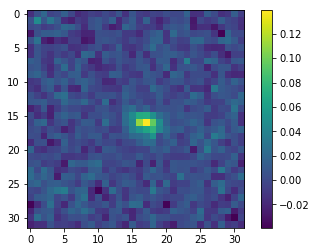

In [60]:
imshow(im[0,:,:,0]);colorbar()